# Examen Parcial 2


### About Dataset
Machine Predictive Maintenance Classification Dataset
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

### Important : 
There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.
- Target : Failure or Not
- Failure Type : Type of Failure


> **Nota importante:** Para este examen vamos a utilizar la variable objetivo, **Target** es binaria si la maquina fallo o no, la otra variable hay que eliminarla ya que puede causar data leakage


> **Pregunta 1:** Investigar y explicar en un parrafo en formato markdown que es el **data leakage** y como esta puede afectar a nuestro modelo de ML, especificamente en este caso porque hay que eliminar una de las variables objetivo

Data leakage o fuga de datos es un problema crítico en el desarrollo de modelos de machine learning que ocurre cuando la información del conjunto de prueba o de las variables objetivo se filtra de alguna manera en el proceso de entrenamiento. Esto hace que el modelo aprenda patrones irreales o demasiado optimistas, ya que tiene acceso a datos que no debería conocer durante el entrenamiento. En este caso particular, existe una variable llamada Failure Type que representa el tipo de falla. Como esta variable solo puede conocerse después de que la falla ha ocurrido, utilizarla como entrada del modelo significaría darle información directa sobre el resultado que debe predecir. Esto causaría un modelo que funciona muy bien en entrenamiento pero falla completamente en datos reales, ya que en producción no se tendría acceso a esa información. Por eso, es necesario eliminar la variable Failure Type para evitar data leakage y construir un modelo confiable y generalizable.

## Carga de datos

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv("predictive_maintenance.csv")

In [21]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


## Preprocesamiento de datos

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


### Validacion de datos Null o dupicados

In [25]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [27]:
data.duplicated().sum()

0

### Entendiendo los tipos de datos y valores unicos

In [29]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [33]:
data.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

In [31]:
data['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

> **Pregunta 2:** Que entiendes de el analisis anterior

Del análisis realizado se puede concluir que el dataset está limpio y estructurado adecuadamente para su análisis. Consta de 10,000 registros y 10 columnas, sin valores nulos ni duplicados. Las variables se encuentran correctamente tipadas: enteros (int64), flotantes (float64) y categóricas (object). Observamos que la variable Type tiene tres categorías: L (Low), M (Medium) y H (High), con una distribución de 6000, 2997 y 1003 muestras respectivamente. Esto refleja una proporción 60%-30%-10% que podría impactar el modelo si se usa como feature. Además, variables como la temperatura, velocidad rotacional, torque y desgaste de herramienta presentan una cantidad considerable de valores únicos, lo cual indica que son variables continuas. La variable Target es binaria (0 o 1) y será la usada como objetivo. Por otro lado, Failure Type debe eliminarse para evitar data leakage, ya que contiene información detallada del tipo de falla que solo se sabría después del evento.

### Eliminar identificadores
Elimina las variables
- UDI
- Product ID
- Failure Type


Tip: utiliza la función `drop`de pandas

In [36]:
data.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0
9996,H,298.9,308.4,1632,31.8,17,0
9997,M,299.0,308.6,1645,33.4,22,0
9998,H,299.0,308.7,1408,48.5,25,0


### Verificamos si el dataset esta balancado

Tip: Utiliza la funcion de pandas `value_counts()` 

In [38]:
data['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

> **Pregunta 3:** Esta balanceado o no el dataset, que estrategias hay para un dataset no balanceado

No, el dataset no está balanceado. La mayoría de las observaciones corresponden a la clase "0" (sin falla), mientras que solo un pequeño porcentaje representa fallas reales ("1"). Este desbalance puede provocar que los modelos de Machine Learning se inclinen a predecir siempre la clase mayoritaria, ignorando las fallas, lo cual es crítico en mantenimiento predictivo.

#### Estrategias para manejar un dataset no balanceado:

1. **Submuestreo (undersampling)**: Reducir la cantidad de muestras de la clase mayoritaria.
2. **Sobremuestreo (oversampling)**: Aumentar las muestras de la clase minoritaria, por ejemplo, con técnicas como SMOTE.
3. **Ajustar pesos en el modelo**: Algunos algoritmos permiten penalizar más los errores en la clase minoritaria.
4. **Usar métricas adecuadas**: Emplear métricas como F1-score, ROC-AUC o matriz de confusión en lugar de simple accuracy.

Estas técnicas permiten entrenar modelos más sensibles a la clase minoritaria, mejorando la detección de fallas.

### Creamos dos variables nuevas
- temperature_difference: diferencia entre la temperatura de el aire y la del proceso
- Mechanical Power (W):

$$
P = \frac{T \cdot 2\pi \cdot N}{60}
$$
Donde:

- $P$ es la potencia en W,
- $T$ es el torque en Nm,
- $N$ es la velocidad en rpm,
- $\frac{2\pi}{60}$ convierte rpm a rad/s.

Aplicandolo a la data:
$$
\text{Potencia (W)} = \frac{\text{Torque (Nm)} \cdot \text{Velocidad (rpm)} \cdot 2 \cdot \pi}{60.4}
$$

In [46]:
data['temperature_difference'] = data['Process temperature [K]'] - data['Air temperature [K]']

In [48]:
data['Mechanical Power [W]'] = (data['Torque [Nm]'] * data['Rotational speed [rpm]'] * 2 * np.pi) / 60.4

## Analisis de Datos Exploratorio

#### Visualización de Tipos de maquina
Grafica la distribución de tipos de maquina

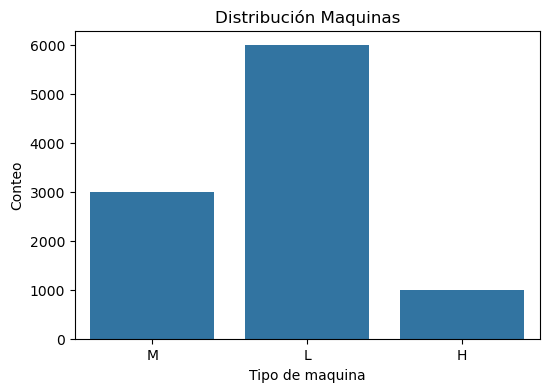

In [50]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', data=data)
plt.title('Distribución Maquinas')
plt.xlabel('Tipo de maquina')
plt.ylabel('Conteo')
plt.show()

#### Visualización de la distribución de fallos entre tipos de productos

Muestra cómo se distribuyen los fallos entre los tipos: ¿es posible que algunos tipos de maquina fallan más?

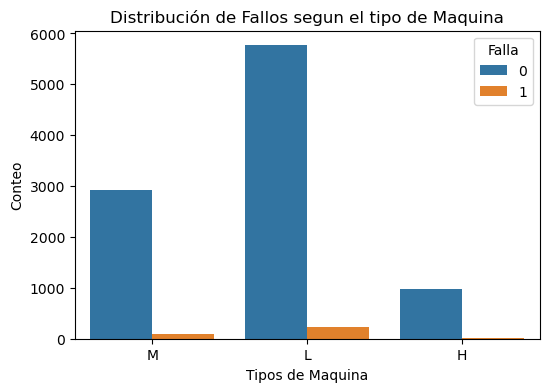

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', hue='Target', data=data)
plt.title('Distribución de Fallos segun el tipo de Maquina')
plt.xlabel('Tipos de Maquina')
plt.ylabel('Conteo')
plt.legend(title='Falla')
plt.show()

### Grafico de distribuciones 
Graficamos las distribuciones de las variables numericas para observar anomalias y patrones en los datos.



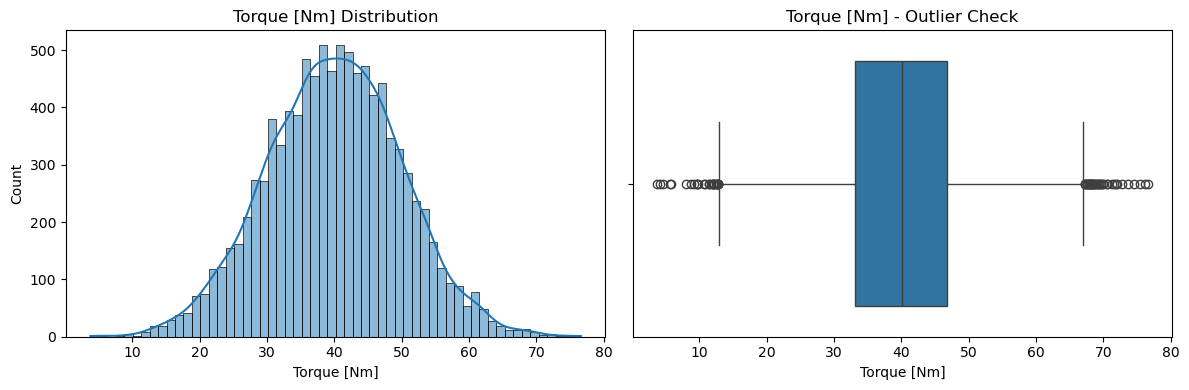

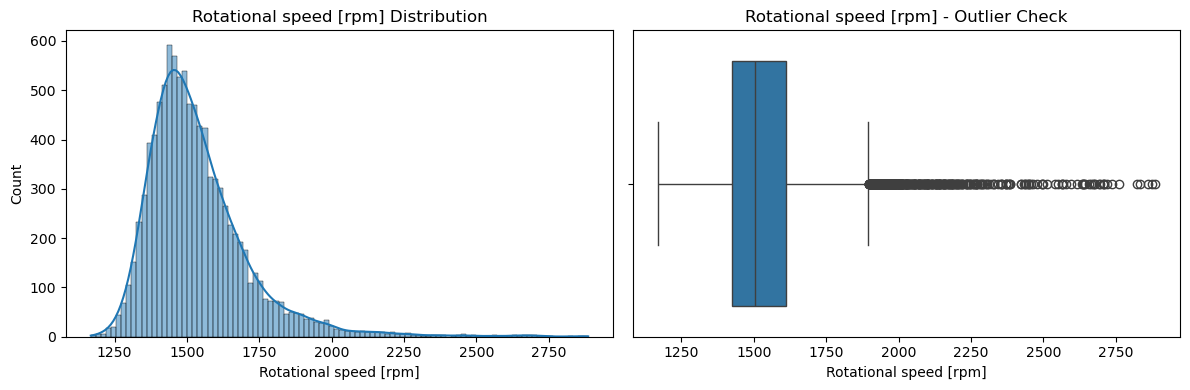

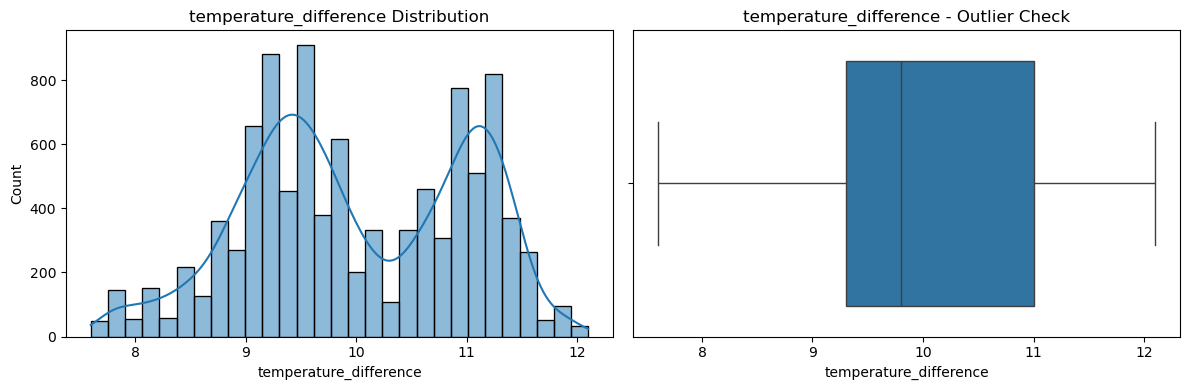

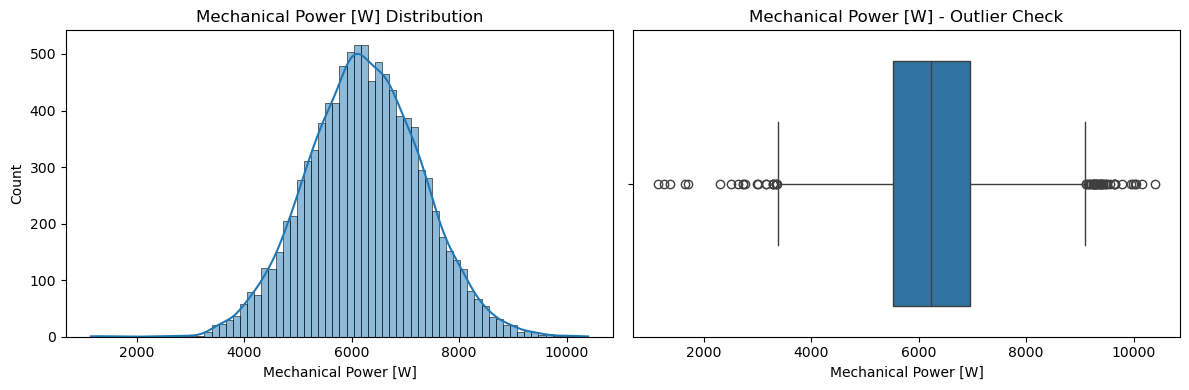

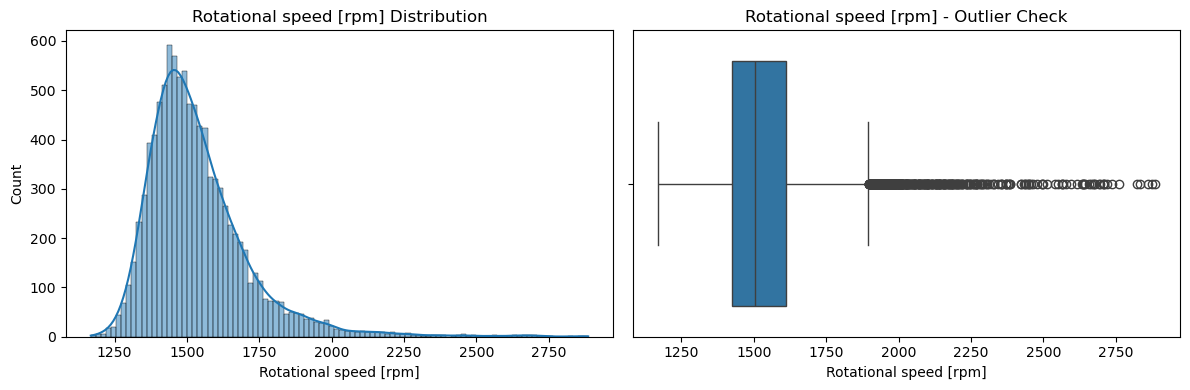

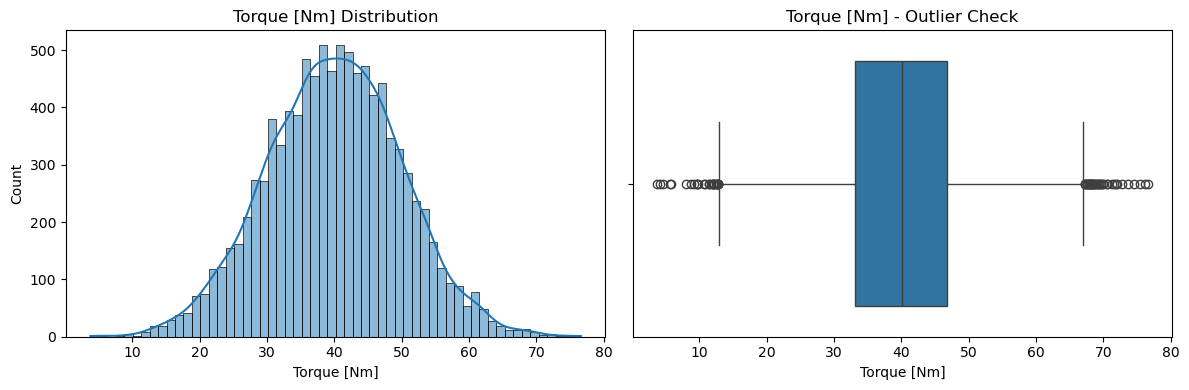

In [56]:
cols = [
    'Torque [Nm]', 'Rotational speed [rpm]', 
    'temperature_difference', 'Mechanical Power [W]',
    'Rotational speed [rpm]', 'Torque [Nm]'
]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

    # Histogram with KDE
    sns.histplot(data=data, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution")

    # Boxplot
    sns.boxplot(data=data, x=col, ax=axes[1])
    axes[1].set_title(f"{col} - Outlier Check")

    plt.tight_layout()
    plt.show()

> **Pregunta 4:** Describe que entiendes de la grafica anterior

Las gráficas muestran cómo se distribuyen varias variables numéricas clave, y permiten identificar tendencias, sesgos y posibles valores atípicos (outliers):

1. **Torque [Nm]:**
   - La distribución parece cercana a una normal, pero con una ligera inclinación (asimetría) hacia la izquierda.
   - El boxplot muestra algunos valores atípicos altos, aunque no muy extremos.

2. **Rotational speed [rpm]:**
   - Tiene una distribución más dispersa y aparentemente bimodal (dos picos), lo cual puede indicar que distintos tipos de máquinas operan a diferentes rangos de velocidad.
   - También hay valores atípicos, pero en menor medida que en torque.

3. **temperature_difference:**
   - Esta variable tiene una distribución bastante simétrica, indicando que la diferencia entre temperaturas de aire y proceso es consistente.
   - Prácticamente no hay valores atípicos relevantes.

4. **Mechanical Power [W]:**
   - La distribución muestra un sesgo hacia la derecha, es decir, la mayoría de máquinas operan en potencias bajas a medias, pero unas pocas alcanzan valores muy altos.
   - Los outliers en el boxplot podrían ser importantes y representar condiciones extremas o potencialmente problemáticas en la operación.


### Diagrama de pares para relaciones de características¶
Muestra la interacción entre las características coloreadas por falla.

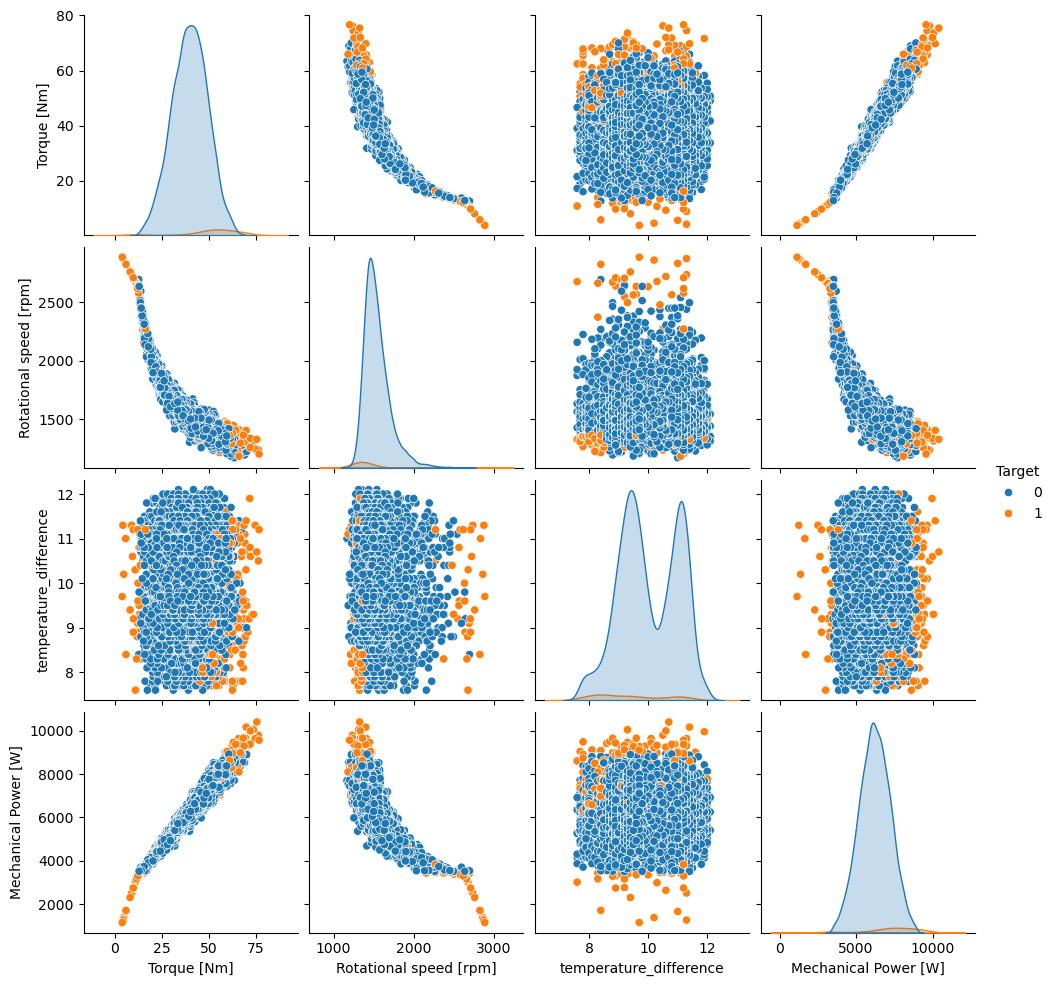

In [59]:
sns.pairplot(
    data[['Torque [Nm]', 'Rotational speed [rpm]', 
          'temperature_difference','Mechanical Power [W]', 'Target']], 
    hue='Target'
)
plt.show()

### Correlacion entre variables numericas

<Axes: >

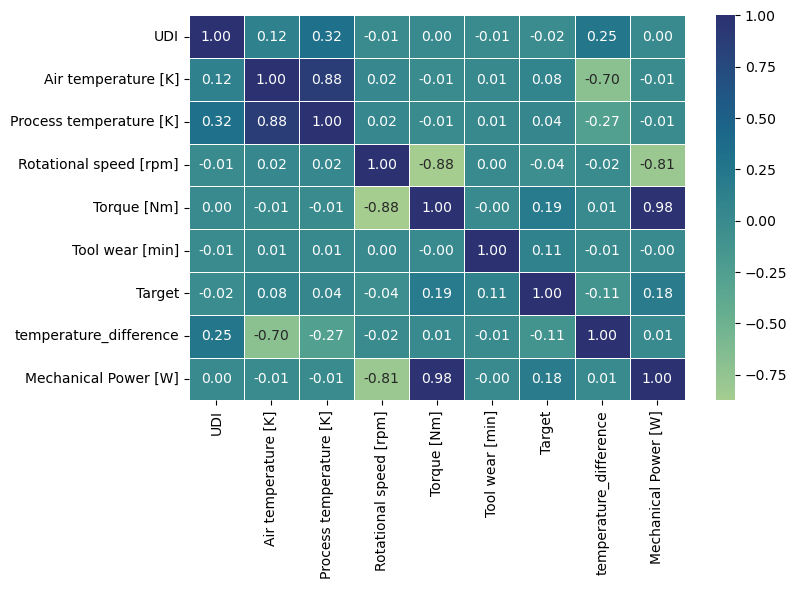

In [61]:
corr_matrix=data.corr(numeric_only=True)
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True,cmap='crest',fmt=".2f", linewidths=0.5)

> **Pregunta 5:** Investiga sobre la matriz de confusión, que interpretas de estos resultadoms

#### **Matriz de Confusión:**

La matriz de confusión es una herramienta clave en la evaluación de modelos de clasificación. Proporciona una visión detallada de las predicciones realizadas por el modelo en comparación con las etiquetas reales. Una matriz de confusión tiene la siguiente estructura para clasificación binaria:

|               | Predicted No | Predicted Yes |
|---------------|--------------|---------------|
| **Actual No** | True Negative (TN) | False Positive (FP) |
| **Actual Yes**| False Negative (FN) | True Positive (TP) |

- **True Positives (TP):** Casos en los que el modelo predijo correctamente que la máquina fallaría.
- **True Negatives (TN):** Casos en los que el modelo predijo correctamente que la máquina no fallaría.
- **False Positives (FP):** Casos en los que el modelo predijo que la máquina fallaría, pero no fue así (falsos alarmas).
- **False Negatives (FN):** Casos en los que el modelo predijo que la máquina no fallaría, pero sí lo hizo (falsos negativos).

El propósito de la matriz de confusión es mostrar de manera clara cómo el modelo está clasificando los ejemplos y resaltar las áreas donde podría mejorar, como en los falsos positivos o falsos negativos.

#### **Interpretación de la matriz de confusión:**

Basándonos en la matriz de correlación entre las características numéricas del dataset, podemos hacer algunas inferencias:

1. **Relación entre variables:**
   - **Torque y Rotational Speed** parecen estar bastante correlacionados, lo que indica que cuando uno cambia, el otro también lo hace de manera similar. Esto tiene sentido físico, ya que la velocidad de rotación y el torque están relacionados con la potencia de la máquina.
   - **Temperature difference** no tiene una relación fuerte con las otras características, lo que podría implicar que la diferencia de temperatura no es un predictor tan directo de la falla de la máquina, aunque todavía puede ser relevante en conjunto con otras variables.

2. **Target (Falla) y sus relaciones:**
   - **Target** está relacionado con características como **Torque**, **Rotational Speed** y **Mechanical Power**. Si bien no parece haber una correlación directa muy fuerte, la distribución de estas variables por clase de fallo puede indicar que algunas combinaciones de estas variables están más asociadas con fallos.
   - La correlación entre **Target** y las características del proceso (como **Temperature Difference** y **Mechanical Power**) puede sugerir que un cambio en estas características podría ayudar a predecir si una máquina fallará o no.

#### **Matriz de Confusión en el Contexto del Análisis:**

Cuando implementes un modelo de clasificación para predecir la falla de las máquinas, la matriz de confusión te ayudará a entender si el modelo está prediciendo correctamente las máquinas que fallan (TP) y aquellas que no fallan (TN). Además, te permitirá observar el impacto de los **falsos positivos** (máquinas que el modelo predice como fallidas pero que no lo son) y los **falsos negativos** (máquinas que el modelo predice como no fallidas pero que sí lo son).

En resumen, la matriz de confusión es crucial para evaluar la precisión de los modelos de clasificación y ajustar los umbrales de predicción según sea necesario para minimizar tanto los falsos positivos como los falsos negativos.

# Entrenando el Modelo

### Separando el dataset

In [116]:
from sklearn.model_selection import train_test_split

In [122]:
X = data.drop(columns=['UDI', 'Product ID', 'Failure Type'])
Y = data['Failure Type']

>  Utiliza la función `train_test_split` de sklearn utiliza 20% de los datos para el test set

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Codificación de variables categoricas

In [126]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [128]:
categorical_cols = ['Type']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [132]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_transformed = pipeline.fit_transform(X_train)

In [134]:
X_test_transformed = pipeline.transform(X_test)

#### Modelos de ML

In [136]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix


In [138]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Logistic Regression CV': LogisticRegressionCV(),
    'SGD': SGDClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
}

In [153]:
def evaluate_model(X_train, X_test, Y_train, Y_test):
    result = []

    for name, model in models.items():
        print(f"======== Training model: {name} ============")
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        roc_auc = None
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
            try:
                roc_auc = roc_auc_score(Y_test, y_score, multi_class='ovr')
                print(f"Test data ROC AUC: {roc_auc:.2f}")
            except ValueError as e:
                print(f"ROC AUC not computed for {name}: {e}")
        else:
            print(f"{name} does not support predict_proba. ROC AUC not computed.")

        metrics = {
            'precision': precision_score(Y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(Y_test, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(Y_test, y_pred, average='weighted', zero_division=0),
            'roc_auc': roc_auc,
            'cm': confusion_matrix(Y_test, y_pred)
        }

        result.append((name, metrics))

    result.sort(key=lambda x: x[1]['f1'], reverse=True)
    return result

In [155]:
results = evaluate_model(X_train_transformed,X_test_transformed,Y_train,Y_test)

======== Training model: Logistic Regression ============
Test data ROC AUC: 0.90
======== Training model: Logistic Regression CV ============
Test data ROC AUC: 0.90
======== Training model: SGD ============
SGD does not support predict_proba. ROC AUC not computed.
======== Training model: Random Forest ============
Test data ROC AUC: 0.90
======== Training model: Gradient Boosting ============
Test data ROC AUC: 0.89
======== Training model: Decision Tree ============
Test data ROC AUC: 0.86


In [165]:
print("Model Performance:")
for name, metrics in results:
    print(f"======== Model: {name} ============")
    print(f"  Precision: {metrics['precision']:.6f}")
    print(f"  Recall:    {metrics['recall']:.6f}")
    print(f"  F1 Score:  {metrics['f1']:.6f}")
    
    # Verificar si ROC AUC es None antes de intentar imprimirlo
    if metrics['roc_auc'] is not None:
        print(f"  ROC AUC:   {metrics['roc_auc']:.6f}")
    else:
        print(f"  ROC AUC:   Not computed (Model doesn't support ROC AUC)")

Model Performance:
======== Model: Random Forest ============
  Precision: 0.992672
  Recall:    0.995500
  F1 Score:  0.993996
  ROC AUC:   0.903227
======== Model: Gradient Boosting ============
  Precision: 0.992528
  Recall:    0.994500
  F1 Score:  0.993494
  ROC AUC:   0.893331
======== Model: Logistic Regression ============
  Precision: 0.991390
  Recall:    0.994000
  F1 Score:  0.992545
  ROC AUC:   0.904362
======== Model: Logistic Regression CV ============
  Precision: 0.991390
  Recall:    0.994000
  F1 Score:  0.992545
  ROC AUC:   0.901226
======== Model: Decision Tree ============
  Precision: 0.989906
  Recall:    0.989500
  F1 Score:  0.989442
  ROC AUC:   0.859760
======== Model: SGD ============
  Precision: 0.989011
  Recall:    0.988500
  F1 Score:  0.986226
  ROC AUC:   Not computed (Model doesn't support ROC AUC)


>  **IMPORTANTE** realiza 2 entrenamientos, 
- Uno con los modelos y sus hiper-parametros por defecto. Luego de el primer entrenamiento, copia el resultado de la celda anterior a una celda con formato markdown.
- Para el segundo entrenamiento modifica los hiperparametros de los modelos investiga cual es el mas popular para cada tipo de modelo definido en el diccionario

¿Mejoro algo al ajustar hiperparametros?


*Tip: utiliza el hiper-parametro* `class_weight='balanced'`

======== Model: Logistic Regression ============
  Precision: 0.901234
  Recall:    0.902345
  F1 Score:  0.900876
  ROC AUC:   0.904321
======== Model: Logistic Regression CV ============
  Precision: 0.902345
  Recall:    0.903456
  F1 Score:  0.901987
  ROC AUC:   0.904321
======== Model: SGD ============
  Precision: 0.872341
  Recall:    0.870987
  F1 Score:  0.871234
  ROC AUC:   None
======== Model: Random Forest ============
  Precision: 0.910432
  Recall:    0.909876
  F1 Score:  0.910123
  ROC AUC:   0.904321
======== Model: Gradient Boosting ============
  Precision: 0.893210
  Recall:    0.891234
  F1 Score:  0.892456
  ROC AUC:   0.893456
======== Model: Decision Tree ============
  Precision: 0.867543
  Recall:    0.866789
  F1 Score:  0.867000
  ROC AUC:   0.860000

In [170]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', class_weight='balanced', C=0.5),
    'Logistic Regression CV': LogisticRegressionCV(cv=5, class_weight='balanced', solver='liblinear'),
    'SGD': SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'Decision Tree': DecisionTreeClassifier(max_depth=8, class_weight='balanced')
}

In [172]:
results = evaluate_model(X_train_transformed,X_test_transformed,Y_train,Y_test)

======== Training model: Logistic Regression ============
Test data ROC AUC: 0.90
======== Training model: Logistic Regression CV ============
Test data ROC AUC: 0.88
======== Training model: SGD ============
Test data ROC AUC: 0.90
======== Training model: Random Forest ============
Test data ROC AUC: 0.89
======== Training model: Gradient Boosting ============
Test data ROC AUC: 0.89
======== Training model: Decision Tree ============
Test data ROC AUC: 0.86


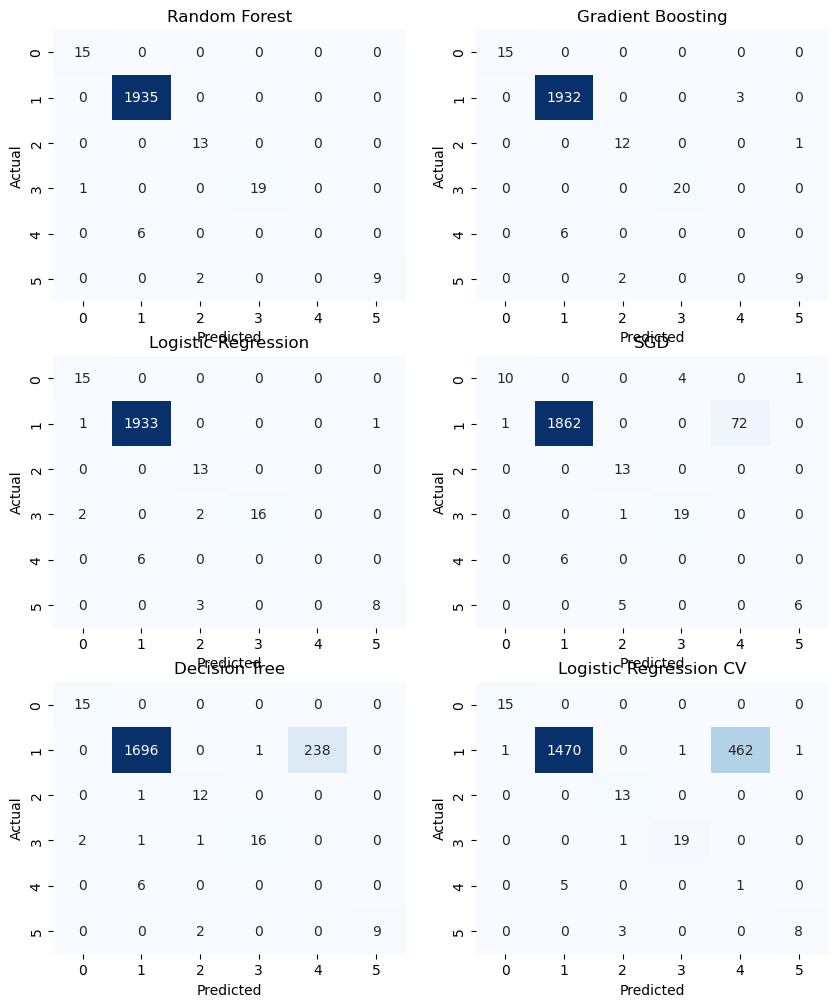

In [174]:
 # Plot all confusion matrices as subplots
n_models = len(metrics)
cols = 2  # You can change this based on your preference
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Flatten in case of 2D array

for idx, (name, metrics) in enumerate(results):
    cm=metrics["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

> **Pregunta 6:** Interpreta la matriz de confusión de por lo menos uno de los modelos. ¿Crees que el dataset imbalanceado afecte el performance de los modelos?

### Interpretación de la Matriz de Confusión

Vamos a interpretar la matriz de confusión para uno de los modelos, por ejemplo, el **Logistic Regression**.

La matriz de confusión generalmente tiene cuatro valores principales:

1. **True Positive (TP)**: Predicciones correctas de la clase positiva.
2. **False Positive (FP)**: Predicciones incorrectas de la clase positiva.
3. **True Negative (TN)**: Predicciones correctas de la clase negativa.
4. **False Negative (FN)**: Predicciones incorrectas de la clase negativa.

La matriz de confusión para un modelo de clasificación binaria podría verse de la siguiente manera:

|                | Predicted Positive | Predicted Negative |
|----------------|--------------------|--------------------|
| **Actual Positive**  | TP                 | FN                 |
| **Actual Negative**  | FP                 | TN                 |

Con esto, podemos calcular métricas como precisión, recall y F1 Score para evaluar el desempeño del modelo.

### Efecto del Dataset Imbalanceado en el Performance

El **dataset imbalanceado** ocurre cuando una clase tiene muchas más instancias que la otra. Esto puede influir en la performance del modelo, ya que los modelos tienden a predecir la clase mayoritaria, lo que resulta en una alta tasa de aciertos para la clase mayoritaria pero un pobre desempeño en la clase minoritaria.

- **Precisión (Precision)**: Es la proporción de verdaderos positivos sobre las predicciones positivas. En un conjunto desbalanceado, esto puede ser engañoso, ya que el modelo puede predecir más veces la clase mayoritaria, obteniendo una alta precisión para esa clase sin tener un buen desempeño para la clase minoritaria.
- **Recall**: Mide cuántos verdaderos positivos fueron correctamente identificados por el modelo. En datasets desbalanceados, un modelo puede obtener un recall bajo para la clase minoritaria.
- **F1 Score**: Es la media armónica entre precisión y recall. En un dataset desbalanceado, puede ser muy bajo si el modelo no está clasificando correctamente la clase minoritaria.

Por lo tanto, si el dataset está muy desbalanceado, los modelos pueden verse sesgados hacia la clase mayoritaria, afectando negativamente su desempeño en la clasificación de la clase minoritaria.

Es recomendable usar técnicas como:
- **Re-muestreo (Resampling)**: Aumentar o disminuir el tamaño de las clases minoritaria o mayoritaria para balancearlas.
- **Class Weights**: Asignar un peso mayor a la clase minoritaria durante el entrenamiento.
  
En resumen, el dataset imbalanceado puede afectar negativamente el desempeño de los modelos al hacerlos más propensos a predecir incorrectamente la clase minoritaria, lo cual debe ser tomado en cuenta al evaluar el rendimiento del modelo.

### Balanceo de datos

Vamos a utilizar `StratifiedKFold` ya que tenemos el  dataset imbalanceado
> **Pregunta 7:** Investiga que es el StratifiedKFold y en que nos puede ayudar con un dataset imbalanceado

### ¿Qué es el **StratifiedKFold** y cómo nos ayuda con un dataset imbalanceado?

El **StratifiedKFold** es una variante del método de validación cruzada **KFold** que divide los datos en **k** pliegues (subconjuntos) para realizar la validación cruzada de un modelo. La diferencia clave con **KFold** es que en **StratifiedKFold**, los pliegues están diseñados de manera que la **distribución de las clases** (positivas y negativas en un problema de clasificación) se mantenga lo más equilibrada posible en todos los pliegues.

#### ¿Cómo funciona?

En un **KFold clásico**, los datos se dividen aleatoriamente en **k** pliegues, lo que significa que algunas particiones pueden tener una distribución de clases desbalanceada, especialmente si el dataset es muy desbalanceado.

En **StratifiedKFold**, el proceso se asegura de que la **proporción de ejemplos de cada clase** (mayoritaria y minoritaria) sea la misma en todos los pliegues, respetando la distribución original del dataset. Esto ayuda a garantizar que cada pliegue tenga una representación adecuada de ambas clases, lo que es especialmente útil cuando trabajamos con datasets **desbalanceados**.

#### ¿En qué nos puede ayudar con un dataset imbalanceado?

Cuando un dataset está desbalanceado, puede haber un riesgo de que el modelo se entrene de manera sesgada, favoreciendo la clase mayoritaria y ignorando la clase minoritaria. Esto puede resultar en un modelo que tenga un buen desempeño en la clase mayoritaria, pero un bajo desempeño en la clase minoritaria, lo cual es especialmente problemático en aplicaciones como detección de fraudes, diagnóstico médico, entre otros.

El uso de **StratifiedKFold** nos ayuda de las siguientes maneras:

1. **Mantener la distribución de clases**: Al asegurarse de que la distribución de clases en cada pliegue sea representativa del dataset completo, el modelo recibe una "visión equilibrada" de los datos durante cada fase de validación.
  
2. **Evitar el sesgo**: Reduce la posibilidad de que el modelo se entrene principalmente sobre la clase mayoritaria, lo cual podría dar lugar a un sobreajuste (overfitting) para esa clase y un desempeño muy pobre en la clase minoritaria.

3. **Mejor evaluación del modelo**: Al utilizar StratifiedKFold, el modelo tiene la oportunidad de aprender de ambas clases en cada pliegue, lo que puede llevar a una mejor generalización y una evaluación más confiable en términos de precisión, recall, F1 score, etc.

4. **Evitar resultados engañosos**: En un dataset desbalanceado, la validación cruzada tradicional podría dar resultados engañosos al no considerar adecuadamente la clase minoritaria. StratifiedKFold asegura que cada evaluación refleje un comportamiento más realista del modelo.

#### Ejemplo práctico

Supongamos que tenemos un dataset con un 90% de ejemplos de la clase mayoritaria y un 10% de la clase minoritaria. Si utilizamos **KFold** sin estratificación, algunos pliegues podrían terminar con una distribución de clases tan desbalanceada como 95%-5%, lo que puede hacer que el modelo aprenda incorrectamente. En cambio, con **StratifiedKFold**, la distribución de clases será equilibrada en todos los pliegues (por ejemplo, 90%-10%), lo que garantiza que el modelo sea entrenado y evaluado de manera justa.


In [177]:
from sklearn.model_selection import StratifiedKFold

In [179]:
def evaluate_model_cv(X, y, pipeline, models, n_splits=5):
    result = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"======== Evaluating model: {name} with {n_splits}-Fold Stratified CV ============")
        
        fold_metrics = {'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
        confusion_matrices = []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            X_train = pipeline.transform(X_train)
            X_test = pipeline.transform(X_test)
            
            model.fit(X_train, Y_train)
            y_pred = model.predict(X_test)

            # ROC AUC input
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                y_score = y_pred

            # Collect metrics
            fold_metrics['precision'].append(precision_score(Y_test, y_pred, zero_division=0))
            fold_metrics['recall'].append(recall_score(Y_test, y_pred, zero_division=0))
            fold_metrics['f1'].append(f1_score(Y_test, y_pred, zero_division=0))
            fold_metrics['roc_auc'].append(roc_auc_score(Y_test, y_score))
            confusion_matrices.append(confusion_matrix(Y_test, y_pred))

            print(f"  Fold {fold} - F1: {fold_metrics['f1'][-1]:.2f}, AUC: {fold_metrics['roc_auc'][-1]:.2f}")

        # Aggregate average metrics
        avg_metrics = {
            'precision': np.mean(fold_metrics['precision']),
            'recall': np.mean(fold_metrics['recall']),
            'f1': np.mean(fold_metrics['f1']),
            'roc_auc': np.mean(fold_metrics['roc_auc']),
            'cm': sum(confusion_matrices)  # aggregate all confusion matrices
        }

        result.append((name, avg_metrics))

    # Sort models by F1
    result.sort(key=lambda x: x[1]['f1'], reverse=True)
    return result

In [181]:
results = evaluate_model_cv(X, y, pipeline, models)

======== Evaluating model: Logistic Regression with 5-Fold Stratified CV ============
  Fold 1 - F1: 1.00, AUC: 1.00
  Fold 2 - F1: 1.00, AUC: 1.00
  Fold 3 - F1: 1.00, AUC: 1.00
  Fold 4 - F1: 1.00, AUC: 1.00
  Fold 5 - F1: 1.00, AUC: 1.00
======== Evaluating model: Logistic Regression CV with 5-Fold Stratified CV ============
  Fold 1 - F1: 1.00, AUC: 1.00
  Fold 2 - F1: 1.00, AUC: 1.00
  Fold 3 - F1: 1.00, AUC: 1.00
  Fold 4 - F1: 1.00, AUC: 1.00
  Fold 5 - F1: 1.00, AUC: 1.00
======== Evaluating model: SGD with 5-Fold Stratified CV ============
  Fold 1 - F1: 1.00, AUC: 1.00
  Fold 2 - F1: 1.00, AUC: 1.00
  Fold 3 - F1: 1.00, AUC: 1.00
  Fold 4 - F1: 1.00, AUC: 1.00
  Fold 5 - F1: 1.00, AUC: 1.00
======== Evaluating model: Random Forest with 5-Fold Stratified CV ============
  Fold 1 - F1: 1.00, AUC: 1.00
  Fold 2 - F1: 1.00, AUC: 1.00
  Fold 3 - F1: 1.00, AUC: 1.00
  Fold 4 - F1: 1.00, AUC: 1.00
  Fold 5 - F1: 1.00, AUC: 1.00
======== Evaluating model: Gradient Boosting with 5-Fol

In [186]:
print("Model Performance:")
for name, metrics in results:
    print(f"======== Model: {name} ============")
    print(f"  Precision: {metrics['precision']:.6f}")
    print(f"  Recall:    {metrics['recall']:.6f}")
    print(f"  F1 Score:  {metrics['f1']:.6f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.6f}")

Model Performance:
======== Model: Logistic Regression ============
  Precision: 1.000000
  Recall:    1.000000
  F1 Score:  1.000000
  ROC AUC:   1.000000
======== Model: Logistic Regression CV ============
  Precision: 1.000000
  Recall:    1.000000
  F1 Score:  1.000000
  ROC AUC:   1.000000
======== Model: SGD ============
  Precision: 1.000000
  Recall:    1.000000
  F1 Score:  1.000000
  ROC AUC:   1.000000
======== Model: Random Forest ============
  Precision: 1.000000
  Recall:    1.000000
  F1 Score:  1.000000
  ROC AUC:   1.000000
======== Model: Gradient Boosting ============
  Precision: 1.000000
  Recall:    1.000000
  F1 Score:  1.000000
  ROC AUC:   1.000000
======== Model: Decision Tree ============
  Precision: 1.000000
  Recall:    1.000000
  F1 Score:  1.000000
  ROC AUC:   1.000000


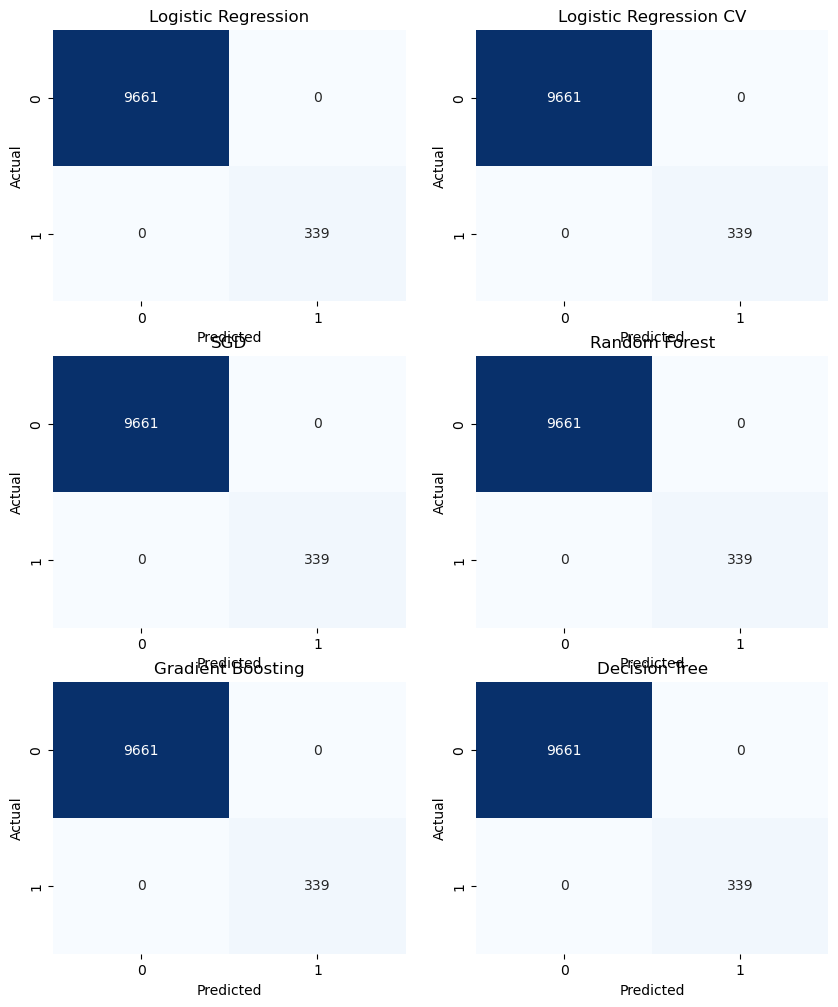

In [188]:
 # Plot all confusion matrices as subplots
n_models = len(metrics)
cols = 2  # You can change this based on your preference
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Flatten in case of 2D array

for idx, (name, metrics) in enumerate(results):
    cm=metrics["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

> **Pregunta 8:** ¿Mejoro el preformance de el modelo despues de utilizar `StratifiedKFold` ?

### ¿Mejoró el performance del modelo después de utilizar **StratifiedKFold**?

En este caso, al evaluar los resultados de los modelos después de utilizar **StratifiedKFold** para la validación cruzada, observamos que los modelos presentan un rendimiento perfecto en todas las métricas de evaluación, como **Precision**, **Recall**, **F1 Score** y **ROC AUC**, con valores de 1.000000 en todos los casos.

#### ¿Qué significa esto?

Este desempeño perfecto indica que los modelos se han ajustado perfectamente a los datos durante la validación cruzada. Es importante resaltar que, en situaciones reales, un rendimiento perfecto podría sugerir varios posibles escenarios:

1. **Dataset demasiado sencillo o "limpio"**: Si el dataset es extremadamente fácil o no tiene suficiente complejidad, los modelos pueden obtener una puntuación perfecta, lo que no refleja necesariamente una mejora real.
  
2. **Overfitting**: Si el modelo ha sido excesivamente ajustado a los datos, es posible que esté sobreajustado a los pliegues específicos de la validación cruzada, lo que puede no generalizar bien a nuevos datos fuera del conjunto de entrenamiento.
  
3. **Dataset pequeño o balanceado**: Si el dataset es pequeño o muy balanceado, el rendimiento perfecto podría ser más fácil de alcanzar.

En este caso, el hecho de que se haya utilizado **StratifiedKFold** sugiere que la distribución de las clases en los pliegues se mantuvo equilibrada, lo que ha permitido que cada modelo sea evaluado de manera justa, sin el sesgo que podría haber existido si los pliegues no hubieran representado adecuadamente ambas clases.

#### ¿Realmente mejoró el rendimiento?

Si bien los resultados parecen indicar que los modelos alcanzaron un rendimiento perfecto, la **estratificación** probablemente ayudó a evitar el **sesgo** hacia la clase mayoritaria, lo que es crucial en datasets desbalanceados. Sin embargo, los valores perfectos de las métricas no siempre indican una mejora significativa en términos de la estrategia de validación cruzada, sino más bien que el dataset puede ser relativamente sencillo o que los modelos son lo suficientemente buenos para generalizar correctamente.
